In [4]:
import os
import glob
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import imblearn

Note: this notebook uses the model from Iter 6 (tpot_221116 514pm Tree More Regularizer) and evaluate it on new labels (called Iter7labels.)

In [5]:
filename = 'tpot_221116 514pm Tree+TrainedIter1Data+EvalIter7Data'

# Cleaning data

### Get data labels

In [6]:
# Get new labels
datalabels_iter7 = pd.read_csv('/Users/travistang/Documents/TorchScene/data/labels/INCA Outlet Image Dataset - oct2022+victor iter7label.csv',index_col=[0])

### Victor_img_df

In [7]:
victor_img_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/csv/fake_merchant_tagging_combined_set_result.csv',index_col = [0])
victor_img_df = victor_img_df.query('outlet_photo_tagging!="Empty"') # Removing empty images
victor_img_df['restaurant_cart_inappropriateness_label'] = victor_img_df['prediction_score'] < 0.6

# Replace Iter 1's labels with Iter 7's labels
# victor_img_df['victor_label_inappropriate_flag'] = victor_img_df.apply(lambda row: 1 if row['outlet_photo_tagging'] == '1' else 0, axis=1) 
victor_img_df = victor_img_df.merge(datalabels_iter7['inappropriate_label_iter7'], how = 'left', left_on = 'saudagar_id', right_index=True)
victor_img_df = victor_img_df.drop(columns=['victor_label_inappropriate_flag'])
victor_img_df = victor_img_df.rename(columns={'inappropriate_label_iter7':'victor_label_inappropriate_flag'})
# Note that outlet_photo_tagging == 1 are those that are tagged as bad by victor because they are fake. the rest are actually good labels

# get group
victor_img_df_val_set = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/victor_img_tpot_df_result tpot_221109 122pm.csv')
victor_img_df = victor_img_df.merge(victor_img_df_val_set[['saudagar_id','group']], how ='left', on ='saudagar_id')
victor_img_df['group'] = victor_img_df['group'].fillna(victor_img_df['set'])

# if a saudagar_id is in validation and test, keep it in validation and drop it from test
victor_img_df = victor_img_df.sort_values('set',ascending=True).drop_duplicates(subset=['source','saudagar_id'],keep='last') 

df_prediction_result = pd.read_csv('/Users/travistang/Documents/TorchScene/result/csv/victor_set_resnet18.csv', index_col = [0])
victor_img_df = victor_img_df.merge(df_prediction_result['pred'], how='inner', left_on = 'saudagar_id', right_index=True)

victor_img_df = victor_img_df.dropna(subset=['victor_label_inappropriate_flag'])

# Get the validation set only so I don't get biased
victor_img_val_df = victor_img_df.query('set == "val"')

victor_img_df

,source,entity_id,saudagar_id,last_action,last_rule,last_sanction_datetime,outlet_photo_url,bank_acc_name,bank_acc_no,cnt_diff_entity_shared_bank_acc,...,restaurant_cart_inappropriateness_label,random,set,restaurant_store_cart_false_positive,restaurant_store_cart_false_negative,label,prediction_score,victor_label_inappropriate_flag,group,pred
0,data,0012s00000NXGa6AAH,G285231232,SuspendMerchantPayout,IBT-M52-009-10A,2022-07-12 9:33:43,https://api.gobiz.co.id/v1/onboardings/data/SF...,MOHAMAD RIDWAN,8.330079e+09,302.0,...,True,0.904060,test,0.0,0.0,NaN,0.000354,1.0,test,burial_chamber 69
2260,good_photos,NaN,G805388509,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.575984,test,0.0,1.0,NaN,0.999973,0.0,test,kindergarden_classroom 202
2261,good_photos,NaN,G024140195,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.575580,test,0.0,1.0,NaN,0.996800,0.0,test,bar 39
2262,good_photos,NaN,G268180486,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.688902,test,0.0,1.0,NaN,0.999392,1.0,test,outdoor 256
2268,good_photos,NaN,G290852858,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.916971,test,0.0,0.0,NaN,0.999991,0.0,test,ticket_booth 332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,good_photos,NaN,G318439890,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.333878,val,0.0,0.0,NaN,0.999969,0.0,val_train,ticket_booth 332
836,data,0012s00000L6Dq9AAF,G559142822,SuspendMerchantGoResto,IBT-M52-015A,2022-08-25 10:45:04,https://api.midtrans.com/v1/onboardings/data/S...,CHANTIKA ALWA PUTRI HEDI,2.316349e+08,4.0,...,False,0.269292,val,NaN,NaN,NaN,0.759632,1.0,val_train,living_room 215
2416,good_photos,NaN,G854199120,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.260184,val,0.0,1.0,NaN,0.992157,1.0,val_train,roof_garden 290
2417,good_photos,NaN,G028282079,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,False,0.118239,val,0.0,1.0,NaN,0.999997,0.0,val_train,loading_dock 216


### Get Oct2022_data

In [8]:
# Read travis' labels from oct2022 set
oct2022_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/labels/Oct2022_TravisLabel.csv')

# # Preprocess victor's label
# victor_new_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/labels/Travis Fake_Merchant_Tagging_2022 - Copy of ML training set addition 2.csv').drop(columns = ['random','set'])
# victor_new_df['victor_label_inappropriate_flag'] = victor_new_df.apply(lambda row: 1 if row['victor_label_inappropriate_flag'] == '1' else 0, axis=1)  # Note that outlet_photo_tagging == 1 are those that are tagged as bad by victor because they are fake. the rest are actually good labels

# # Get victor's label if travis has not labelled
# oct2022_df = oct2022_df.merge(victor_new_df, how = 'left', on = 'restaurant_photo_url')
# oct2022_df['travis_inappropriate_label'].fillna(oct2022_df['victor_label_inappropriate_flag'], inplace=True)
# oct2022_df['inappropriate_label'] = oct2022_df['victor_label_inappropriate_flag'].combine_first(oct2022_df['travis_inappropriate_label'])

# Replace Iter 1's labels with Iter 7's labels
# victor_img_df['victor_label_inappropriate_flag'] = victor_img_df.apply(lambda row: 1 if row['outlet_photo_tagging'] == '1' else 0, axis=1) 
oct2022_df = oct2022_df.merge(datalabels_iter7['inappropriate_label_iter7'], how = 'left', left_on = 'outlet_id', right_index=True)
oct2022_df = oct2022_df.drop(columns=['travis_inappropriate_label'])
oct2022_df = oct2022_df.rename(columns={'inappropriate_label_iter7':'inappropriate_label'})

# Get the embedding for oct2022 set
df_prediction_result_oct2022_gooddata = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/resnet18/oct2022_gooddata_resnet18.csv', index_col = [0])
df_prediction_result_oct2022_baddata = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/resnet18/oct2022_baddata_resnet18.csv', index_col = [0])

df_prediction_result_oct2022 = pd.concat([df_prediction_result_oct2022_gooddata, df_prediction_result_oct2022_baddata])

df_prediction_result_oct2022 = df_prediction_result_oct2022.merge(oct2022_df[['outlet_id','inappropriate_label','group']], 
                                    how = 'left', left_index=True,right_on='outlet_id')

df_prediction_result_oct2022.set_index('outlet_id')

# Drop images that have not been labelled
df_prediction_result_oct2022.dropna(inplace=True)

df_prediction_result_oct2022

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364,outlet_id,inappropriate_label,group
25414.0,2.139274e-07,0.000009,0.000022,5.341184e-03,0.000297,9.620219e-06,0.000250,0.000004,3.967058e-06,0.000024,...,0.001111,2.443199e-06,3.614401e-06,1.677299e-06,8.493458e-05,0.004273,3.606791e-06,G000007135,1.0,train
8729.0,1.175332e-06,0.000005,0.000076,1.025874e-04,0.000170,1.486519e-04,0.000595,0.001543,1.816568e-05,0.000050,...,0.000060,3.128750e-06,9.179776e-06,1.101525e-05,2.041509e-03,0.000012,4.518936e-05,G000051136,0.0,train
15083.0,1.970256e-06,0.000023,0.000921,1.132516e-05,0.001191,1.095202e-04,0.000144,0.010354,3.195454e-04,0.000720,...,0.000061,2.209334e-06,1.783030e-05,3.196685e-05,7.799471e-04,0.000025,2.635096e-04,G000162899,0.0,train
26366.0,2.726324e-06,0.000631,0.000017,1.223479e-02,0.000304,6.293109e-06,0.000534,0.000039,2.232212e-05,0.000116,...,0.000529,2.561831e-06,6.468579e-06,1.141056e-05,1.837652e-05,0.006582,1.709939e-04,G000224606,1.0,train
2207.0,2.137902e-08,0.000001,0.000067,9.194782e-07,0.000004,9.634322e-07,0.008203,0.001622,1.499786e-07,0.000023,...,0.000015,2.604203e-08,5.356325e-08,1.718631e-07,5.244693e-07,0.000004,8.652056e-08,G000224896,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30517.0,4.026394e-06,0.000781,0.000207,8.751875e-03,0.003511,1.261907e-05,0.000161,0.000054,1.577824e-05,0.001119,...,0.001056,2.119998e-05,2.131157e-05,1.032646e-05,1.803221e-04,0.005164,1.103344e-03,G987336045,1.0,train
26012.0,1.040386e-06,0.000566,0.000361,1.985723e-04,0.001025,3.115472e-06,0.001498,0.000154,2.270017e-06,0.000104,...,0.000053,5.551453e-07,6.444111e-07,5.649167e-07,1.306322e-05,0.001769,5.651703e-06,G991154114,1.0,train
30648.0,4.006243e-04,0.000021,0.000067,8.886862e-04,0.000014,8.098442e-05,0.000014,0.000221,4.211369e-05,0.000972,...,0.000155,1.206198e-03,2.263173e-03,1.173708e-03,2.118064e-04,0.000106,1.086916e-03,G993559621,1.0,train
30681.0,1.028183e-04,0.000041,0.000122,6.808520e-03,0.000256,7.076355e-05,0.000031,0.000144,1.150000e-04,0.000743,...,0.000211,2.043070e-04,6.766088e-04,2.385151e-04,4.731342e-04,0.000295,5.668707e-04,G996745489,1.0,train


# Get Baseline Performance of Restaurant Stall Cart

In [9]:
print("Train Set performance")
print(classification_report(victor_img_df.query("group == 'val_train'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'val_train'")['restaurant_cart_inappropriateness_label']))

print("Validation Set performance")
print(classification_report(victor_img_df.query("group == 'val_test'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'val_test'")['restaurant_cart_inappropriateness_label']))


print("Test Set performance")
print(classification_report(victor_img_df.query("group == 'test'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'test'")['restaurant_cart_inappropriateness_label']))


Train Set performance
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       802
         1.0       0.96      0.47      0.63       714

    accuracy                           0.74      1516
   macro avg       0.82      0.73      0.72      1516
weighted avg       0.81      0.74      0.72      1516

Validation Set performance
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       265
         1.0       0.96      0.48      0.64       239

    accuracy                           0.74       504
   macro avg       0.82      0.73      0.72       504
weighted avg       0.81      0.74      0.72       504

Test Set performance
              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       987
         1.0       0.96      0.46      0.62       973

    accuracy                           0.72      1960
   macro avg       0.80      0.72      0.70      1960
weig

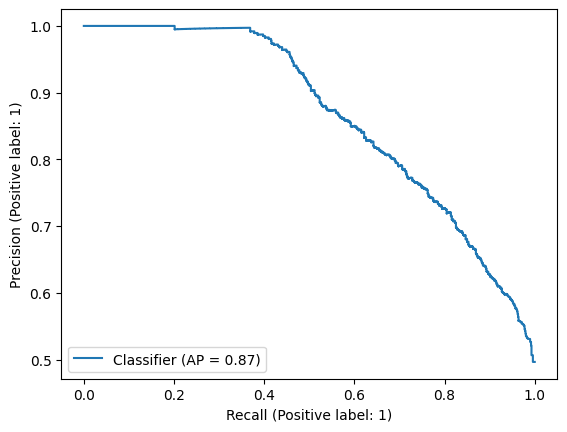

In [10]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(victor_img_df.query("group == 'test'")['victor_label_inappropriate_flag'],
                                        1- victor_img_df.query("group == 'test'")['prediction_score'])

# Exploring the Validation Set

In [11]:
# Finding categories that are highly correlated with inappropriate categories
victor_img_val_explore_str = victor_img_val_df.pivot_table(index = ['pred','restaurant_cart_inappropriateness_label'], columns = 'victor_label_inappropriate_flag', aggfunc = len)['source']

print(victor_img_val_explore_str.to_string())

victor_label_inappropriate_flag                                       0.0   1.0
pred                       restaurant_cart_inappropriateness_label             
airplane_cabin 1           False                                      1.0   NaN
alcove 3                   False                                      2.0   6.0
                           True                                       1.0   5.0
alley 4                    False                                      3.0   7.0
amusement_arcade 6         False                                     39.0   NaN
amusement_park 7           False                                      5.0   NaN
aquarium 9                 True                                       NaN   8.0
archive 14                 False                                      1.0   1.0
                           True                                       NaN   7.0
art_gallery 19             False                                      1.0   1.0
art_school 20              False        

# Using TPOT to train a decision tree classifier for the 365-length vector

### Creating TPOT set for victor_img_df

In [12]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

#Creating a dataframe for tpot only
oct2022_tpot_df = df_prediction_result_oct2022.copy()
oct2022_tpot_df = oct2022_tpot_df.set_index('outlet_id')
# oct2022_tpot_df = oct2022_tpot_df.rename(columns = {'travis_inappropriate_label':'inappropriate_flag'})

target_col = 'inappropriate_label' 

# Making sure this is idempotent
oct_2022_X_train = oct2022_tpot_df.query('group == "train"').drop(columns=[target_col,'group'])
oct_2022_y_train = oct2022_tpot_df.query('group == "train"').drop(columns=['group'])[target_col]
oct_2022_X_test = oct2022_tpot_df.query('group == "val"').drop(columns=[target_col,'group'])
oct_2022_y_test = oct2022_tpot_df.query('group == "val"').drop(columns=['group'])[target_col]

/Users/travistang/opt/anaconda3/envs/torch-scene/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating TPOT Set for Oct_2022

In [13]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

#Creating a dataframe for tpot only
victor_img_tpot_df = victor_img_df.merge(df_prediction_result.drop(columns=['pred']), how='left', left_on = 'saudagar_id', right_index=True)
victor_img_tpot_df = victor_img_tpot_df.dropna(subset=['airfield 0']) 
victor_img_tpot_df = victor_img_tpot_df.set_index('saudagar_id')
victor_img_tpot_df = victor_img_tpot_df.query('set == "val"')

victor_img_tpot_df = victor_img_tpot_df.drop(columns = ['source', 'entity_id', 'last_action', 'last_rule',
       'last_sanction_datetime', 'outlet_photo_url', 'bank_acc_name',
       'bank_acc_no', 'cnt_diff_entity_shared_bank_acc',
       'diff_entity_id_shared_bank_acc',
       'cnt_diff_entity_outlet_shared_bank_acc',
       'diff_entity_outlet_id_shared_bank_acc', 'gofood_id', 'cnt_all_order',
       'sum_gmv_all_order', 'cnt_co', 'sum_gmv_co', 'cnt_maf_defect_order',
       'sum_gmv_maf_defect_order', 'cnt_cadf', 'sum_gmv_cadf', 'percent_co',
       'percent_good_order', 'percent_bad_order', 'photo',
       'outlet_photo_tagging', 'flag_fake_merchant', 'prediction_score',
       'restaurant_cart_inappropriateness_label',
       'random','set',
       'restaurant_store_cart_false_positive','restaurant_store_cart_false_negative','label','pred','group'])

victor_img_tpot_df = victor_img_tpot_df.rename(columns = {'victor_label_inappropriate_flag': 'inappropriate_label'})

target_col = 'inappropriate_label' #restaurant_store_cart_false_positive

X_train, X_test, y_train, y_test = train_test_split(victor_img_tpot_df.drop(columns=[target_col]), 
                                                    victor_img_tpot_df[target_col],
                                                    train_size=0.75, 
                                                    test_size=0.25,
                                                    random_state=42)

# Making sure this is idempotent
# victor_img_df_val_set = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intemediate/victor_img_tpot_df_result tpot_221108 122pm.csv')
# X_train = victor_img_df_val_set.query('group == "val_train"').set_index('saudagar_id').drop(columns=['victor_label_inappropriate_flag','pred','group','inappropriate_prob','outlet_photo_url','prediction_score'])
# y_train = victor_img_df_val_set.query('group == "val_train"')['victor_label_inappropriate_flag']
# X_test = victor_img_df_val_set.query('group == "val_test"').set_index('saudagar_id').drop(columns=['victor_label_inappropriate_flag','pred','group','inappropriate_prob','outlet_photo_url','prediction_score'])
# y_test = victor_img_df_val_set.query('group == "val_test"')['victor_label_inappropriate_flag']


### Merging all TPOT sets

In [14]:
X_train_full = pd.concat([X_train, oct_2022_X_train])
y_train_full = pd.concat([y_train, oct_2022_y_train])
X_test = pd.concat([X_test, oct_2022_X_test])
y_test = pd.concat([y_test, oct_2022_y_test])

In [15]:
# define oversampling strategy
sample = imblearn.over_sampling.SMOTE(random_state = 42)
X_train, y_train = sample.fit_resample(X_train_full, y_train_full)

### Training for TPOT

In [13]:
# from sklearn.ensemble import ExtraTreesClassifier

# tpot = ExtraTreesClassifier(bootstrap=False, 
#                             criterion='gini', 
#                             max_features=0.5,
#                             min_samples_leaf=15, 
#                             min_samples_split=12,
#                             n_estimators=100,
#                             random_state = 35)

# tpot.fit(X_train, y_train)
# print(tpot.score(X_train, y_train))

# Never ran

0.9637330336301547


In [14]:
# import pickle

# try:
#     tpot.export(f'../tpot/{filename}.py')
# except:
#     with open(f'../tpot/{filename}.pkl', 'wb') as model_file:
#         pickle.dump(tpot, model_file)

In [16]:
# load the model from disk
import pickle
tpot = pickle.load(open('/Users/travistang/Documents/TorchScene/tpot/tpot_221116 514pm Tree More Regularizer.pkl', 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

## Evaluate the model

In [17]:
# Making the final result dataset
df_test = victor_img_df.merge(df_prediction_result.drop(columns=['pred']), how='left', left_on = 'saudagar_id', right_index=True)
df_test = df_test.query('set == "test"')
df_test = df_test.dropna(subset=['airfield 0']) 
df_test = df_test.set_index('saudagar_id')
df_test = df_test.drop(columns = ['source', 'entity_id', 'last_action', 'last_rule',
       'last_sanction_datetime', 'outlet_photo_url', 'bank_acc_name',
       'bank_acc_no', 'cnt_diff_entity_shared_bank_acc',
       'diff_entity_id_shared_bank_acc',
       'cnt_diff_entity_outlet_shared_bank_acc',
       'diff_entity_outlet_id_shared_bank_acc', 'gofood_id', 'cnt_all_order',
       'sum_gmv_all_order', 'cnt_co', 'sum_gmv_co', 'cnt_maf_defect_order',
       'sum_gmv_maf_defect_order', 'cnt_cadf', 'sum_gmv_cadf', 'percent_co',
       'percent_good_order', 'percent_bad_order', 'photo',
       'outlet_photo_tagging', 'flag_fake_merchant', 'prediction_score',
       'restaurant_cart_inappropriateness_label',
       'random','set',
       'restaurant_store_cart_false_positive','restaurant_store_cart_false_negative','label','pred','set','group'])

tpot_df = pd.concat([oct2022_tpot_df.drop(columns=['group']),victor_img_tpot_df,df_test.rename(columns = {'victor_label_inappropriate_flag':'inappropriate_label'})])

# Making predictions on inappropriateness using classifier
tpot_df['inappropriate_prob'] = tpot.predict_proba(tpot_df.drop(columns=['inappropriate_label']))[:,1]

# assigning group
tpot_df['group'] = ''
tpot_df.loc[tpot_df.index.isin(victor_img_df_val_set.query('group == "val_train"').saudagar_id),'group']='train'
tpot_df.loc[tpot_df.index.isin(victor_img_df_val_set.query('group == "val_test"').saudagar_id),'group']='val'
tpot_df.loc[tpot_df.index.isin(oct_2022_X_train.index),'group']='train'
tpot_df.loc[tpot_df.index.isin(oct_2022_X_test.index),'group']='val'
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('set == "test"').saudagar_id),'group']='test'

# assigning source
tpot_df['source'] = ''
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="data"').saudagar_id),'source']='data'
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="good_photos"').saudagar_id),'source']='good_photos'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_gooddata.index),'source']='oct2022_gooddata'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_baddata.index),'source']='oct2022_baddata'

# assigning set
tpot_df['set'] = ''
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="data"').saudagar_id),'set']='victor'
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="good_photos"').saudagar_id),'set']='victor'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_gooddata.index),'set']='oct2022'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_baddata.index),'set']='oct2022'

# Merging results
tpot_df = tpot_df.drop_duplicates()
tpot_df[['inappropriate_prob']].to_csv(f'/Users/travistang/Documents/TorchScene/result/intermediate/{filename}/tpot_df.csv')

# Generate a one-off dataset that contains the URL
tpot_df = tpot_df.merge(victor_img_df[['saudagar_id','outlet_photo_url']], how='left',left_index = True, right_on = 'saudagar_id').set_index('saudagar_id')
tpot_df = tpot_df.merge(oct2022_df[['outlet_id','restaurant_photo_url']], how='left',left_index = True, right_on = 'outlet_id')
tpot_df['outlet_photo_url'] = tpot_df['outlet_photo_url'].fillna(tpot_df['restaurant_photo_url'])
tpot_df = tpot_df.drop(columns = ['restaurant_photo_url'])

tpot_df = tpot_df.set_index('outlet_id', drop=True)

tpot_df = tpot_df.drop_duplicates()
tpot_df[['outlet_photo_url','group','source','set','inappropriate_label']].to_csv(f'/Users/travistang/Documents/TorchScene/data/csv/oct2022+victor.csv')


In [18]:
tpot_df

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,windmill 361,yard 362,youth_hostel 363,zen_garden 364,inappropriate_label,inappropriate_prob,group,source,set,outlet_photo_url
outlet_id,,,,,,,,,,,,,,,,,,,,,
G000007135,2.139274e-07,8.877712e-06,0.000022,5.341184e-03,0.000297,9.620219e-06,0.000250,0.000004,3.967058e-06,2.369832e-05,...,1.677299e-06,8.493458e-05,0.004273,3.606791e-06,1.0,0.751642,train,oct2022_gooddata,oct2022,https://api.gobiz.co.id/v1/onboardings/data/SF...
G000051136,1.175332e-06,5.057530e-06,0.000076,1.025874e-04,0.000170,1.486519e-04,0.000595,0.001543,1.816568e-05,5.027789e-05,...,1.101525e-05,2.041509e-03,0.000012,4.518936e-05,0.0,0.008282,train,oct2022_gooddata,oct2022,https://api.gobiz.co.id/v1/onboardings/data/SF...
G000162899,1.970256e-06,2.253714e-05,0.000921,1.132516e-05,0.001191,1.095202e-04,0.000144,0.010354,3.195454e-04,7.204539e-04,...,3.196685e-05,7.799471e-04,0.000025,2.635096e-04,0.0,0.166387,train,oct2022_gooddata,oct2022,https://api.gobiz.co.id/v1/onboardings/data/SF...
G000224606,2.726324e-06,6.312387e-04,0.000017,1.223479e-02,0.000304,6.293109e-06,0.000534,0.000039,2.232212e-05,1.159015e-04,...,1.141056e-05,1.837652e-05,0.006582,1.709939e-04,1.0,0.821917,train,oct2022_gooddata,oct2022,https://api.gobiz.co.id/v1/onboardings/data/SF...
G000224896,2.137902e-08,1.091339e-06,0.000067,9.194782e-07,0.000004,9.634322e-07,0.008203,0.001622,1.499786e-07,2.290889e-05,...,1.718631e-07,5.244693e-07,0.000004,8.652056e-08,0.0,0.000000,train,oct2022_gooddata,oct2022,https://api.gobiz.co.id/v1/onboardings/data/SF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G506427626,8.964552e-05,2.812791e-04,0.000127,2.508922e-02,0.000083,9.770808e-06,0.000157,0.000075,1.187956e-04,2.093857e-03,...,6.131802e-04,1.581691e-04,0.000889,4.262529e-04,1.0,0.984729,test,data,victor,https://api.gobiz.co.id/v1/onboardings/data/SF...
G050841328,2.620510e-06,2.401831e-05,0.000058,3.385504e-02,0.000183,7.213193e-06,0.001122,0.000532,1.453368e-05,1.549785e-03,...,2.462671e-06,1.477298e-03,0.000228,1.822124e-04,1.0,0.469212,test,data,victor,https://api.midtrans.com/v1/onboardings/data/S...
G436006229,1.548531e-04,7.768250e-04,0.000342,3.176613e-02,0.000392,7.352784e-05,0.000043,0.000275,1.506499e-04,1.673141e-03,...,4.613529e-03,1.266370e-04,0.012177,3.188663e-04,1.0,0.997933,test,data,victor,https://api.gobiz.co.id/v1/onboardings/data/SF...


In [19]:
from sklearn.metrics import roc_auc_score
print("Training: Victor+Oct2022")
y_true = tpot_df.query('group=="train"')['inappropriate_label']
y_score = tpot_df.query('group=="train"')['inappropriate_prob']
y_pred = y_score >= 0.5
print(f'the auc score is {roc_auc_score(y_true,y_score)}')
print(classification_report(y_true,y_pred, digits=3))

print("Training: Victor+Oct2022+SMOTE Oversampled")
y_pred = tpot.predict(X_train)
y_score = tpot.predict_proba(X_train)[:,1]
print(f'the auc score is {roc_auc_score(y_train,y_score)}')
print(classification_report(y_train,y_pred, digits=3))


Training: Victor+Oct2022
the auc score is 0.9887269587602008
              precision    recall  f1-score   support

         0.0      0.987     0.938     0.962     23104
         1.0      0.797     0.953     0.868      5928

    accuracy                          0.941     29032
   macro avg      0.892     0.945     0.915     29032
weighted avg      0.948     0.941     0.943     29032

Training: Victor+Oct2022+SMOTE Oversampled
the auc score is 0.9901260292116426
              precision    recall  f1-score   support

         0.0      0.959     0.938     0.949     23134
         1.0      0.939     0.960     0.950     23134

    accuracy                          0.949     46268
   macro avg      0.949     0.949     0.949     46268
weighted avg      0.949     0.949     0.949     46268



Validation: Victor+Oct2022
the auc score is 0.9813200926596932
              precision    recall  f1-score   support

         0.0      0.982     0.923     0.951      2738
         1.0      0.771     0.938     0.847       759

    accuracy                          0.926      3497
   macro avg      0.877     0.931     0.899      3497
weighted avg      0.936     0.926     0.929      3497

Validation: Victor set
the auc score is 0.9815602151576641
              precision    recall  f1-score   support

         0.0      0.949     0.927     0.938       262
         1.0      0.922     0.945     0.933       237

    accuracy                          0.936       499
   macro avg      0.936     0.936     0.936       499
weighted avg      0.936     0.936     0.936       499



(array([0.4749499 , 0.48865979, 0.48966942, 0.49170124, 0.49478079,
        0.4958159 , 0.49685535, 0.49789916, 0.5       , 0.50105708,
        0.50211864, 0.50318471, 0.50425532, 0.50533049, 0.50749465,
        0.50858369, 0.50967742, 0.51077586, 0.51187905, 0.51298701,
        0.51409978, 0.51521739, 0.51633987, 0.51746725, 0.51859956,
        0.51973684, 0.52087912, 0.52202643, 0.52317881, 0.52433628,
        0.52549889, 0.52666667, 0.52783964, 0.52901786, 0.53020134,
        0.53139013, 0.53258427, 0.53378378, 0.53498871, 0.5361991 ,
        0.53741497, 0.53863636, 0.53986333, 0.54109589, 0.5423341 ,
        0.54357798, 0.54482759, 0.54608295, 0.54734411, 0.54861111,
        0.54988399, 0.55116279, 0.55244755, 0.55373832, 0.55503513,
        0.55633803, 0.55764706, 0.55896226, 0.56028369, 0.56161137,
        0.56294537, 0.56428571, 0.56563246, 0.56698565, 0.56834532,
        0.56971154, 0.57108434, 0.57246377, 0.57384988, 0.57524272,
        0.57664234, 0.57804878, 0.5794621 , 0.58

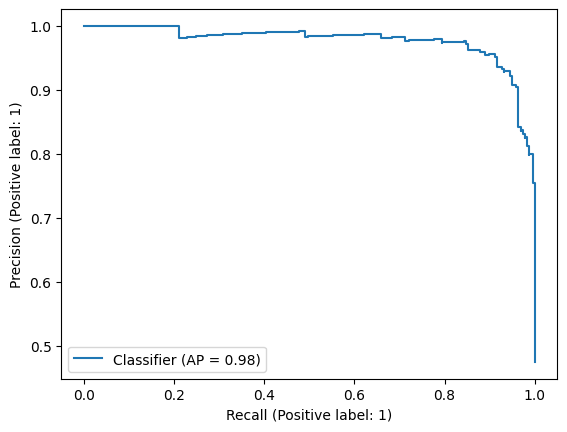

In [20]:
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, precision_recall_curve
print("Validation: Victor+Oct2022")
y_true = tpot_df.query('group=="val"')['inappropriate_label']
y_score = tpot_df.query('group=="val"')['inappropriate_prob']
y_pred = y_score >= 0.5
print(f'the auc score is {roc_auc_score(y_true,y_score)}')
print(classification_report(y_true,y_pred, digits=3))

print("Validation: Victor set")
y_true = tpot_df.query('group=="val" & set == "victor"')['inappropriate_label']
y_score = tpot_df.query('group=="val" & set == "victor"')['inappropriate_prob']
y_pred = y_score >= 0.5
print(f'the auc score is {roc_auc_score(y_true,y_score)}')
print(classification_report(y_true,y_pred, digits=3))

PrecisionRecallDisplay.from_predictions(y_true, y_score)
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
precision, recall, thresholds


Test: Victor set
the auc score is 0.9736565068396867
Classification report when threshold is 0.3
              precision    recall  f1-score   support

         0.0      0.951     0.856     0.901       987
         1.0      0.867     0.955     0.909       973

    accuracy                          0.905      1960
   macro avg      0.909     0.905     0.905      1960
weighted avg      0.909     0.905     0.905      1960

Classification report when threshold is 0.3025
              precision    recall  f1-score   support

         0.0      0.951     0.858     0.902       987
         1.0      0.869     0.955     0.910       973

    accuracy                          0.906      1960
   macro avg      0.910     0.906     0.906      1960
weighted avg      0.910     0.906     0.906      1960

Classification report when threshold is 0.305
              precision    recall  f1-score   support

         0.0      0.949     0.861     0.903       987
         1.0      0.871     0.953     0.910    

(array([0.49642857, 0.51102941, 0.51129795, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.01233299, 0.01130524,
        0.        ]),
 array([0.00000000e+00, 3.44827586e-04, 3.57142857e-04, ...,
        9.99500000e-01, 9.99615385e-01, 1.00000000e+00]))

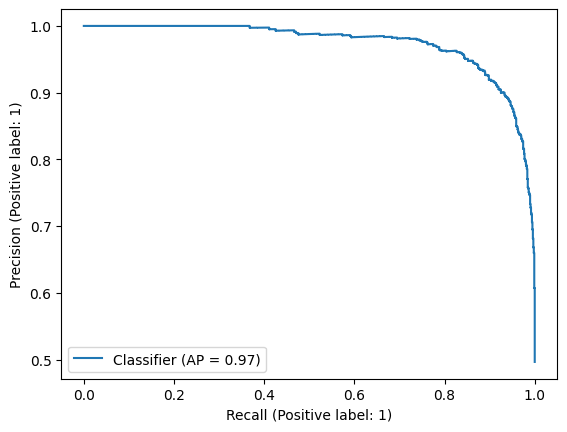

In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
print("Test: Victor set")
# drop_cols = ['group','source','set','inappropriate_prob','outlet_photo_url']
y_true = tpot_df.query('group=="test"')['inappropriate_label']
y_score = tpot_df.query('group=="test"')['inappropriate_prob']

print(f'the auc score is {roc_auc_score(y_true,y_score)}')

for thres in np.arange(0.3,1,0.0025):
       print(f"Classification report when threshold is {thres}")
       print(classification_report(y_true,y_score > thres, digits = 3))

PrecisionRecallDisplay.from_predictions(y_true, y_score)
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

precision, recall, thresholds
